# I. Creating Quantum Circuits

In [4]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml

Using Pennylane I create two quantum circuits below:

1) Circuit 1: \
   a) 5 qubits \
   b) Hadamard operation on every qubit \
   c) CNOT operation on (0,1), (1,2), (2,3), (3,4) \
   d) SWAP (0,4) \
   e) Rotate X with pi/2 on first qubit 

2) Circuit 2: \
   a) Hadamard gate to the first qubit \
   b) Rotation to second qubit by pi/3 around X \
   c) Hadamard gate to third and fourth qubits \
   d) SWAP test between states of first and second qubit and the third and fourth qubit.


In [5]:

# Specify the device
dev = qml.device("default.qubit")


@qml.qnode(dev)
def circuit_1(n_qubits):

    # Apply Hadamard gate to all qubits
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Apply CNOT gate to wires i, i+1
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # Apply SWAP gate to qubits 0 and 4
    qml.SWAP(wires=[0, 4])
    # Apply X rotation by pi/2 to qubit 1
    qml.RX(np.pi / 2, wires=1)
    
    # Return the probabilities of all qubits
    return qml.probs(wires=range(n_qubits))

@qml.qnode(dev)
def circuit_2(n_qubits):

    # Apply Hadamard gate to qubit 1
    qml.Hadamard(wires=0)
    # Apply X rotation by pi/3 to qubit 2
    qml.RX(np.pi / 3, wires=1)
    # Apply Hadamard gate to qubits 3 and 4
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)

    # Perform SWAP tests between qubit 1 and 3 and qubit 2 and 4
    # With qubits 5 and 6 being the ancillary qubits for each respective test
    qml.Hadamard(wires=4)
    qml.Hadamard(wires=5)
    qml.CSWAP(wires=[4, 0, 2])
    qml.CSWAP(wires=[5, 1, 3])
    qml.Hadamard(wires=4)
    qml.Hadamard(wires=5)

    return qml.expval(qml.PauliZ(4)), qml.expval(qml.PauliZ(5))
    

Circuit 1:


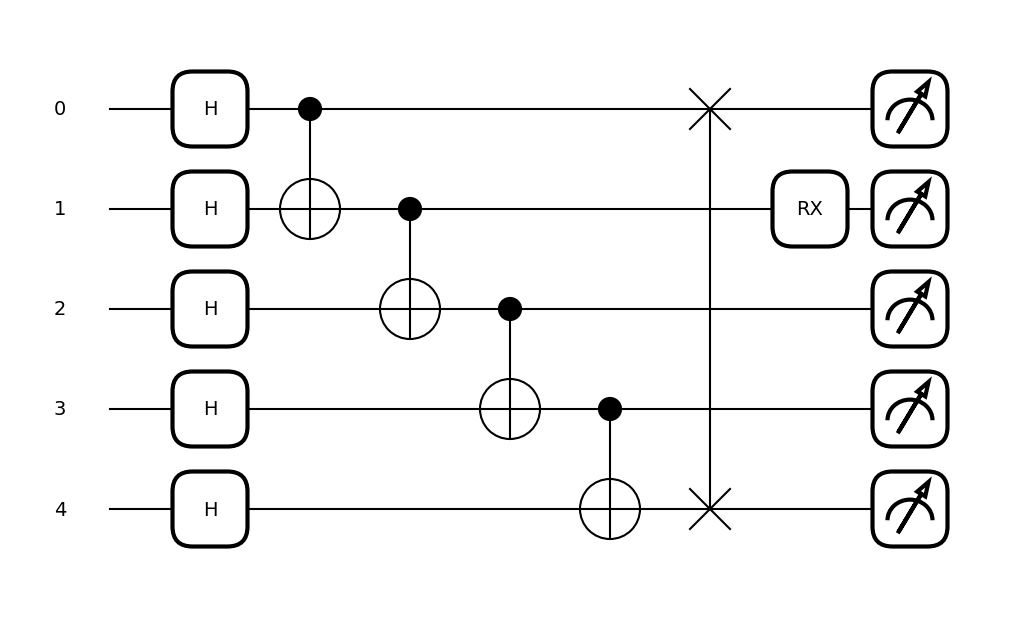

Circuit 2:


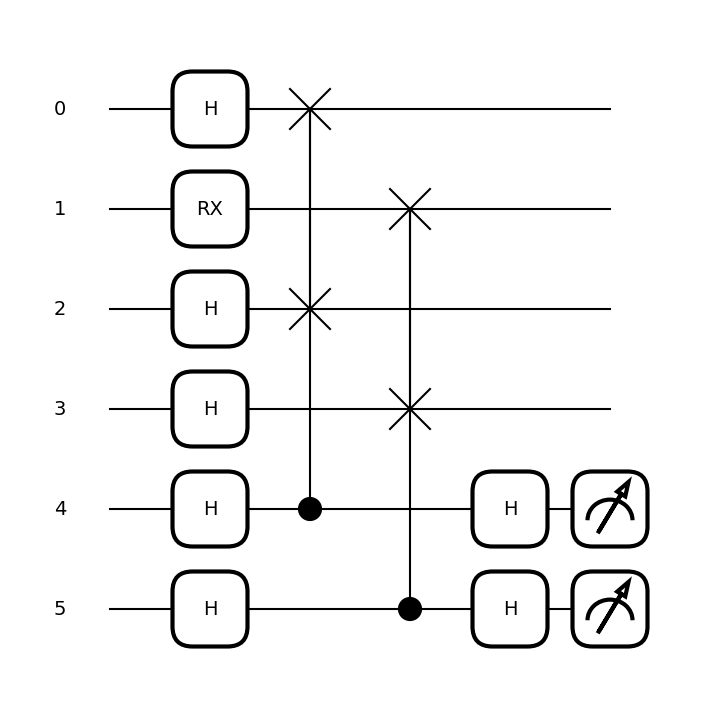

In [6]:
# Draw the circuits

print("Circuit 1:")
fig, ax = qml.draw_mpl(circuit_1)(5)
plt.show()
print("Circuit 2:")
fig, ax = qml.draw_mpl(circuit_2)(6)
plt.show()

------------------------------------------------------------------------------------------------

# II. Classical Graph Neural Network (GNN)

## The dataset

I use ParticleNet's data [[1]](https://zenodo.org/records/3164691#.YigdGt9MHrB) for Quark/Gluon jet classification.

This contains data with the following structure:

- X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.
- y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.


In [16]:
X = np.load("X.npy")
y = np.load("y.npy")

# Convert to long format
y = y.astype("long")
y = y[:2000]

## Processing the data

I follow the methods indicated in [[2]](https://inspirehep.net/literature/2698788) to process the data.

Firstly, I construct a graph for each jet, where each node corresponds to a particle within the jet and the feature set of each particle is assigned to the node.

I define the edges in this graph using the K-nearest neighbour algorithm, where the distances are defined in the $\eta$-$\phi$ space, where $\eta$, $\phi$ are the rapidity and azimuthal angle, respectively, as defined in columns 2 and 3 in the feature set.

In [13]:
import dgl
from sklearn.neighbors import NearestNeighbors
import torch


def create_graphs(N):
    """
    Function to create the graph using the K-nearest neighbor algorithm.
    N defines what length of the datasets (X, y) to use.
    """
    # Define the number of neighbours
    k = 3
    # Implement the neighbor search
    neigh = NearestNeighbors(n_neighbors=k)
    
    # Define a list for the graphs
    graph_list = []
    counter = 0
    # Iterate over the jet and labels in X and y
    for jet, label in zip(X[:N],y[:N]):
        # Number of particles defined by length of array within jet
        n_particles = jet.shape[0]
        # Initialise a graph
        g = dgl.graph([])
        # Add a node for each particle
        g.add_nodes(n_particles)
        # Define the features for each node
        g.ndata['feat'] = torch.tensor(jet, dtype=torch.float32)

        # Construct the eta-phi space
        eta = jet[:,1]
        phi = jet[:,2]
        eta_phi_space = np.column_stack((eta, phi))
        # Fit the nearest neighbours
        neigh.fit(eta_phi_space)
        _, indices = neigh.kneighbors(eta_phi_space)

        # Iterate over each node to define the edges
        for i in range(n_particles):
            for neighbor_index in indices[i]:
                if neighbor_index != i:
                    g.add_edges(i, neighbor_index)

        # Add the graph to the list
        graph_list.append(g)
        counter += 1
    
        if counter % 100 == 0:
            print(counter)

    return graph_list

graph_list = create_graphs(2000)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


## Define the model

In the next step I construct the model to tag the jets.

I define the PCN-Lite [[2]](https://anvilproject.org/guides/content/creating-links) model. Which utilises Chebyshev Graph Convolutions (ChebConv).

In [19]:
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F

class PCN_Lite(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(PCN_Lite, self).__init__()

        # Define the Chebyshev convolutional layers
        self.conv1 = dgl.nn.ChebConv(in_feats, hidden_feats, 2)
        self.conv2 = dgl.nn.ChebConv(hidden_feats, hidden_feats, 2)
        self.conv3 = dgl.nn.ChebConv(hidden_feats, hidden_feats, 2)

        # Define the fully connected layer
        self.fc = nn.Linear(hidden_feats, out_feats)

    # Perform the forward pass
    def forward(self, g, h):
        # Apply ReLU activation after each ChebConv layer
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        h = F.relu(self.conv3(g, h))

        # Update node features in the graph
        g.ndata['h'] = h

        # Global mean pooling
        hg = dgl.mean_nodes(g, 'h')

        # Pass graph through fully connected layer
        out = self.fc(hg)

        # Apply softmax function to the output
        return F.log_softmax(out, dim=1)



## Training

Next, perform the training on the dataset.

In [21]:
from dgl.dataloading import GraphDataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim

# Split the data into training, validation, and testing
graph_train, graph_temp, y_train, y_temp = train_test_split(graph_list, y, test_size=0.2, random_state=42)
graph_val, graph_test, y_val, y_test = train_test_split(graph_temp, y_temp, test_size=0.5, random_state=42)

# Define the batch size
batch_size = 32

# Construct dataloaders for training, validation, and testing
train_loader = GraphDataLoader(
    list(zip(graph_train, y_train)),
    batch_size = batch_size,
    shuffle=True,
    drop_last=False
)

val_loader = GraphDataLoader(
    list(zip(graph_val, y_val)),
    batch_size = batch_size,
    shuffle=True,
    drop_last=False
)

test_loader = GraphDataLoader(
    list(zip(graph_test, y_test)),
    batch_size = batch_size,
    shuffle=True,
    drop_last=False
)

# Define number of features, hidden dimensions, and Quark/Gluon classes
num_features = len(X[0][0])
hidden_dim = 64
num_classes = 2

# Initialise the model
model = PCN_Lite(num_features, hidden_dim, num_classes)


def evaluate(dataloader, model):
    """
    Evaluate the model on the dataset.
    dataloader contains the dataset and
    model defines the model to be used.
    """
    # Set to evaluation mode
    model.eval()
    total = 0
    correct = 0
    for batched_graph, labels in dataloader:
        total += len(labels)
        # Exctract node features
        feat = batched_graph.ndata["feat"]
        # Perform forward pass
        logits = model(batched_graph, feat)
        # Return predictions
        _, predicted = torch.max(logits, 1)
        # Add correct predictions to 'correct'
        correct += (predicted == labels).sum().item()
    # Calculate the accuracy 
    acc = 1.0 * correct / total
    return acc

def train(train_loader, val_loader, model):
    """
    Train the model, where train_loader and validation_loader
    contain the training and validationd datasets and model 
    defines the model to be used.
    """
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimiser
    opt = optim.Adam(model.parameters(), lr=0.001)

    # Iterate over the epochs
    for epoch in range(50):
        # Set to training mode
        model.train()
        total_loss = 0
        for batch, (batched_graph, labels) in enumerate(train_loader):
            # Extract node features
            feat = batched_graph.ndata["feat"]
            # Perform forward pass
            logits = model(batched_graph, feat)
            # Compute the loss
            loss = criterion(logits, labels)
            # Reset gradients to zero
            opt.zero_grad()
            # Backpropagation
            loss.backward()
            # Update weights
            opt.step()
            # Compute the total loss
            total_loss += loss.item()
        # Evaluate on training and validation datasets
        train_acc = evaluate(train_loader, model)
        val_acc = evaluate(val_loader, model)
        # Return the epoch number, loss, training accuracy, validation accuracy
        print(
            f"Epoch {epoch} | Loss {total_loss / (batch + 1)} | Train Acc. {train_acc} | Val Acc. {val_acc}"
        )

train(train_loader, val_loader, model)
    
        

    
        

/home/wiktor/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/wiktor/.local/lib/python3.10/site-packages/dgl/nn/pytorch/conv/chebconv.py:108: DGLWarning: lambda_max is not provided, using default value of 2.  Please use dgl.laplacian_lambda_max to compute the eigenvalues.
  dgl_warning(


Epoch 0 | Loss 0.7399106252193451 | Train Acc. 0.674375 | Val Acc. 0.575
Epoch 1 | Loss 0.628502950668335 | Train Acc. 0.708125 | Val Acc. 0.675
Epoch 2 | Loss 0.588388461470604 | Train Acc. 0.72875 | Val Acc. 0.71
Epoch 3 | Loss 0.5475818049907685 | Train Acc. 0.73125 | Val Acc. 0.705
Epoch 4 | Loss 0.5242293816804886 | Train Acc. 0.731875 | Val Acc. 0.685
Epoch 5 | Loss 0.5333643639087677 | Train Acc. 0.743125 | Val Acc. 0.7
Epoch 6 | Loss 0.5237276315689087 | Train Acc. 0.74625 | Val Acc. 0.685
Epoch 7 | Loss 0.5183065646886825 | Train Acc. 0.7475 | Val Acc. 0.7
Epoch 8 | Loss 0.515252314209938 | Train Acc. 0.756875 | Val Acc. 0.7
Epoch 9 | Loss 0.5081768065690995 | Train Acc. 0.754375 | Val Acc. 0.725
Epoch 10 | Loss 0.509689153432846 | Train Acc. 0.75875 | Val Acc. 0.69
Epoch 11 | Loss 0.5112425422668457 | Train Acc. 0.738125 | Val Acc. 0.72
Epoch 12 | Loss 0.5112652224302292 | Train Acc. 0.75875 | Val Acc. 0.73
Epoch 13 | Loss 0.4974993097782135 | Train Acc. 0.771875 | Val Acc. 0

--------------------------------------------------------------------------------------------------

# III. Quantum computing

## Quantum computing

Quantum computing takes advantage of quantum mechanics and provides an alternate way of processing information. With classical computers operating with bits that can be in two states: 1 and 0, quantum computers utilise qubits, which exist in a superposition of those basis states: 1 and 0. 

This principle can allow for quantum computers to solve complex problems exponentially faster than classical computing, such as drug development, financial modelling, and cybersecurity. 

This quantum advantage is already evident in understanding quantum systems, such as with the boson sampling algorithm, which considers quantum interference experiments in optical networks. Due to the parallel computation capabilities of qubits, multiple possible configurations can therefore be calculated at once, allowing for exponential speedup compared to classical computers. 

## Quantum machine learning

Quantum machine learning lies at the intersection between quantum computing and machine learning, leveraging the capabilities of quantum computation to speed up machine learning models. 

Since quantum technologies allow for exponentially greater storage and processing power, its advantages in processing large amount of information are therefore evident for machine learning.

Quantum machine learning for example can be for solving linear algebraic problems, performing principal component analysis, support vector machines, optimisation, and deep learning problems.

In particle physics, machine learning algorithms can be boosted with quantum computation to capture quantum correlations in datasets more efficiently than classical machine learning algorithms. 

One example [[4]](https://arxiv.org/abs/2104.05059) uses a quantum support vector machine to classify data, such as collisions that produce or do not produce the Higgs boson.

One area I would love to work on is in exploring quantum neural networks. In terms of particle physics, neural networks are of great importance to analysing high energy physics data, from online triggers to offline data analysis. Additionally, graph neural networks in particular have a significant influence particle physics as data can often be represented using sets and graphs. 

With the High Luminosity LHC (HL-LHC) program around the corner, large volumes of data will continue to be produced which current algorithms will be unable to process. 

Investigating quantum machine learning techniques to efficiently reconstruct event information is therefore of great importance and improving time complexity of current classical algorithms is something I would love to contribute to.

--------------------------------------------------------------------------------------------------

# V. Quantum Graph Neural Network (QGNN)

## Introduction

An interesting quantum graph neural network is the ‘hybrid quantum classical graph neural network for particle track reconstruction’ [[5]](https://link.springer.com/article/10.1007/s42484-021-00055-9) posed to solve the problem of determining particle trajectories in the HL-LHC.

The basic principle of particle track reconstruction is to identify the trajectory of particles based on signals, known as “hits”, as they traverse through the detectors. This is a significant challenge at the HL-LHC upgrade due to the increase in number of particles produced during collisions. Quantum computing however can provide a solution to speed up this immense computational task.

The hybrid quantum-classical graph neural network (QGNN) approach is a solution to this particle reconstruction problem. This tactic utilises a graph representation to construct the particle trajectories, such that “hits” present in the detector layers are classed as nodes and the connections between adjacent layers are potential edges. This graph is then taken as an input and the output returned is the probability for each edge, denoting whether an edge correctly corresponds to a track segment, thus recreating the particle trajectories. 

## Architecture

The QGNN architecture comprises of three parts: (I) The input network, which increases the dimension of the input data by passing coordinates through a single fully connected NN layer to an output size corresponding to the hidden dimension size, which is then concatenated to form an initial node feature vector. (ii) This node feature vector is fed to the Edge and Node Networks, which iteratively process the graph, and finally (iii) the Edge Network is used to return the final edge probabilities. 

The architecture schematic is displayed here:

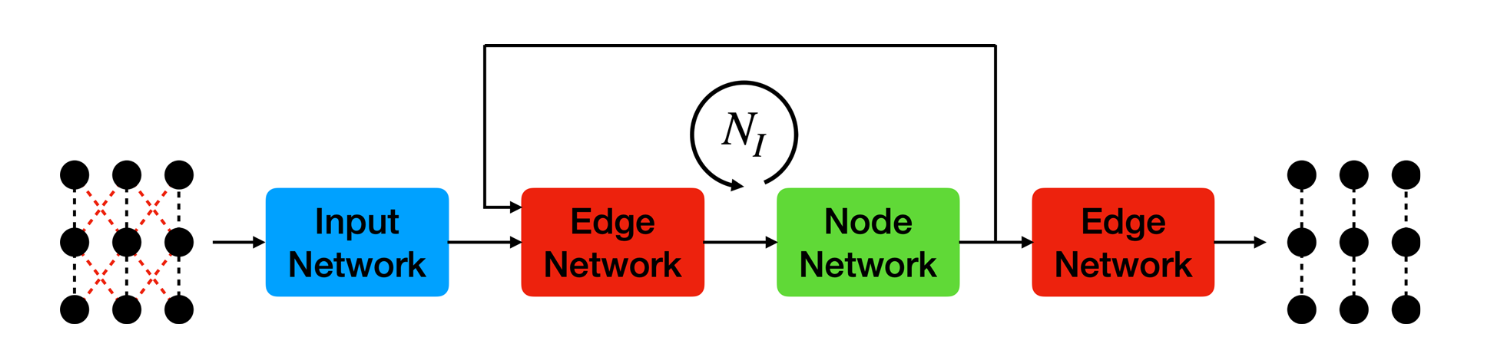

### The Edge Network

The Edge Network in this architecture takes a pair of nodes and returns the probability for those nodes to be connected. It concatenates node feature vectors from input and output nodes of each edge and feeds them into a Hybrid Neural Network (HNN) to compute the edge probabilities. 

### The Node Network

The Node Network receives the input from the Edge Network and updates the node features. It creates triplets combining each node with its neighbouring nodes from the upper and lower detector layers, which are then processed by the HNN to create updated node features. 

### Hybrid Neural Network

It is the Hybrid Neural Network (HNN) which contains the quantum computational part of the architecture, combining both classical and quantum layers. The structure of this network starts with a single fully connected neural network which outputs a layer with dimension equal the the number of qubits in the quantum layer. The measurements from this quantum layer are then passed onto another fully connected neural network which has an output dimension of 1 in the case of the Edge Network, and N_D (corresponding to the hidden dimension) in the case of the Node Network.

The architecture for the HNN is displayed here:

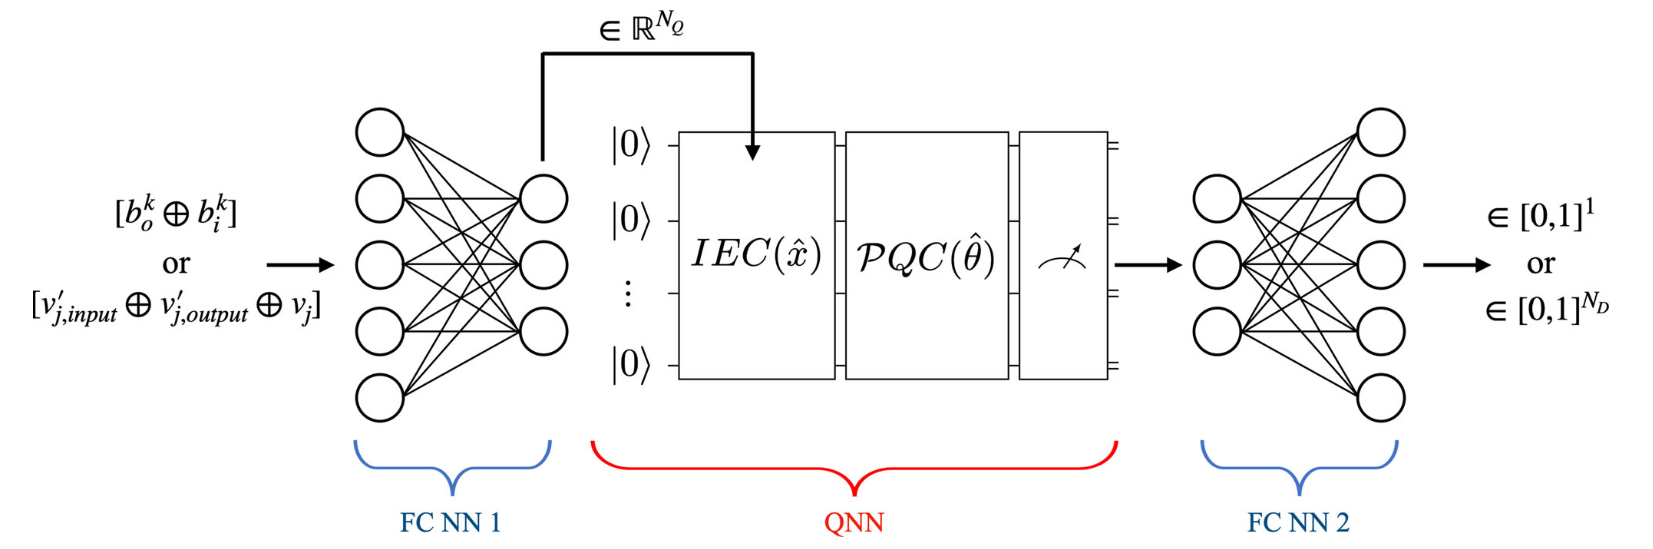 

### Quantum Neural Network

The Quantum Neural Network (QNN) present in the quantum layer, as chosen by the [reference], contains three parts: (I) An information encoding circuit (IEC) to encode the classical data to qubit states, (ii) the parametrized quantum circuit (PQC) to transform these states to the Hilbert Space, and (iii) measurements along the z-axis using the Pauli-Z operator.  

The information encoding part is done with angle encoding, employing rotational gates to return a unique and bijective representation of the classical data. This rotation maps the states to be within the range 0 to pi, ensuring uniqueness holds due to the periodicity of the cosine function, which allows for later meaningful measurements to be made with the Pauli-Z operator.

Following this is the PQC element, which is the part of the quantum layer that undergoes training to achieve the desired output. In the paper, two types of PQC’s are considered: (I) Matrix Product State (MPS) and (ii) Tree Tensor Network (TTN). 

The following circuits are constructed below:

MPS Circuit:


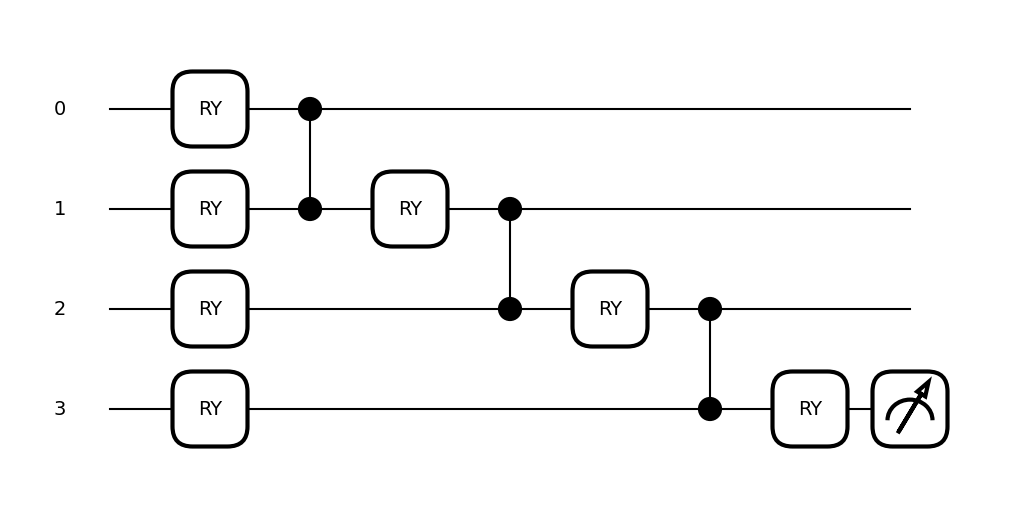

TTN Circuit:


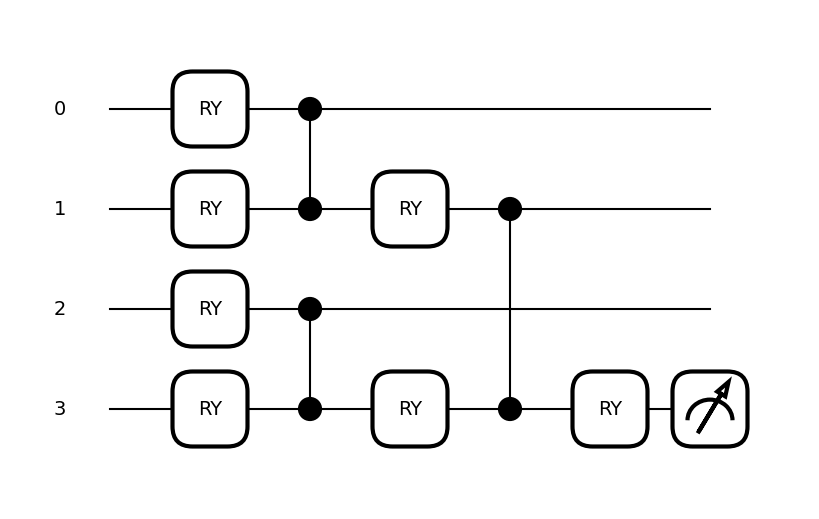

Circuit 19: 


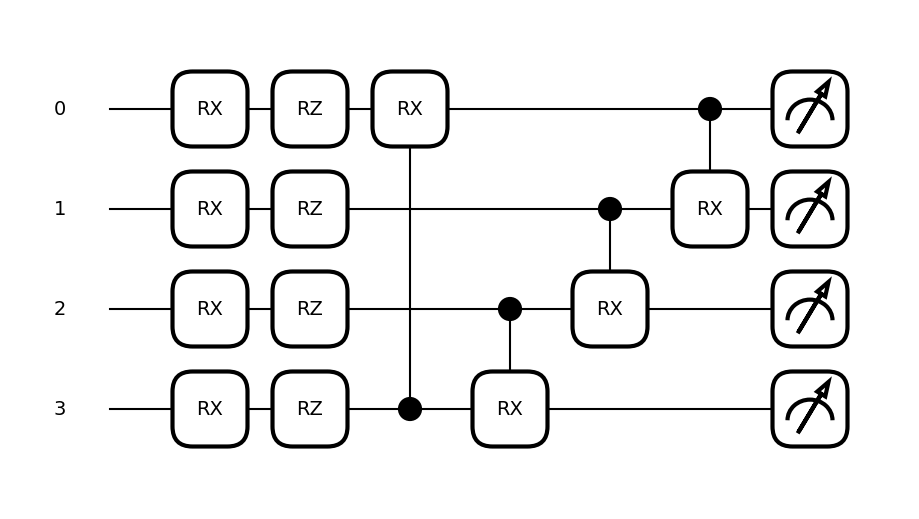

Circuit 10: 


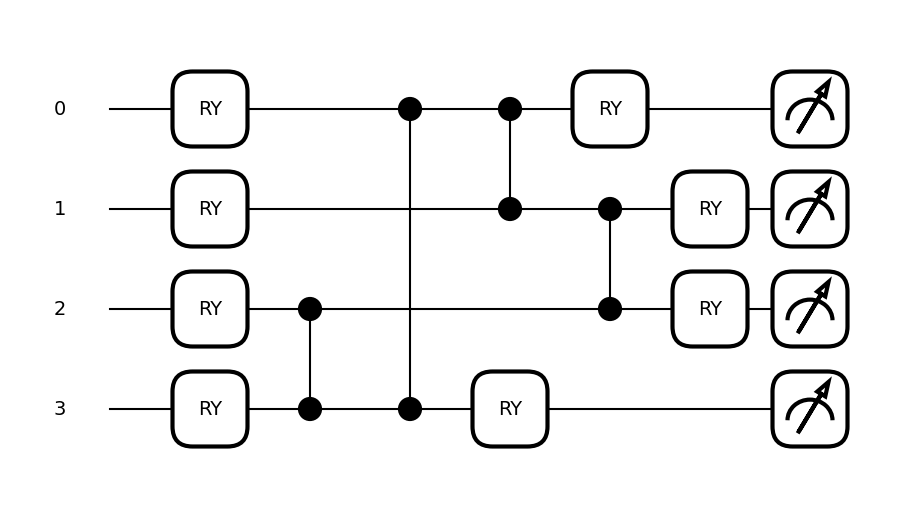

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml


@qml.qnode(dev)
def MPS(n_qubits, phi):
    # Apply Y rotation by phi to all qubits
    for i in range(n_qubits):
        qml.RY(phi, wires=i)

    # Apply CZ and rotation gates
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i + 1])
        qml.RY(phi, wires=i + 1)

    return qml.expval(qml.PauliZ(3))


@qml.qnode(dev)
def TTN(n_qubits, phi):
    # Apply Y rotation by phi to all qubits
    for i in range(n_qubits):
        qml.RY(phi, wires=i)

    # Apply Controlled-Z gate 
    qml.CZ(wires=[0, 1])
    qml.CZ(wires=[2, 3])

    # Apply Y rotation by phi to qubits 1 and 3
    qml.RY(phi, wires=1)
    qml.RY(phi, wires=3)

    # Controlled-Z gate
    qml.CZ(wires=[1, 3])

    # Y rotation by phi to qubit 3
    qml.RY(phi, wires=3)

    return qml.expval(qml.PauliZ(3))


@qml.qnode(dev)
def circuit_19(n_qubits, phi):

    # Apply X, Z rotation by phi to all qubits
    for i in range(n_qubits):
        qml.RX(phi, wires=i)
        qml.RZ(phi, wires=i)

    # Apply controlled rotation gates
    qml.CRX(phi, wires=[3, 0])

    
    for i in reversed(range(1, n_qubits)):
        qml.CRX(phi, wires=[i - 1, i])

    expectation = [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    return expectation


@qml.qnode(dev)
def circuit_10(n_qubits, phi):

    # Apply Y rotation by phi to all qubits
    for i in range(n_qubits):
        qml.RY(phi, wires=i)

    # Apply Controlled-Z gates
    qml.CZ(wires=[2, 3])
    qml.CZ(wires=[0, 3])
    qml.CZ(wires=[0, 1])
    qml.CZ(wires=[1, 2])

    # Apply Y rotation by phi to all qubits
    for i in range(n_qubits):
        qml.RY(phi, wires=i)

    expectation = [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    return expectation

# Draw the circuits
print("MPS Circuit:")
fig, ax = qml.draw_mpl(MPS)(4, np.pi / 2)
plt.show()

print("TTN Circuit:")
fig, ax = qml.draw_mpl(TTN)(4, np.pi / 2)
plt.show()

print("Circuit 19: ")
fig, ax = qml.draw_mpl(circuit_19)(4, np.pi / 2)
plt.show()

print("Circuit 10: ")
fig, ax = qml.draw_mpl(circuit_10)(4, np.pi / 2)
plt.show()


## Training the QNN

The trainable parameters within this network are the (i) axis of angle embedding, (ii) number of layers, (iii) number of iterations, and (iv) hidden dimension size. Overall, in comparing these hyperparameters against each one another, circuit 10 performed the best among the other models. 

## Further work

The work in this paper explores whether there is an advantage in reducing the high dimensional NN layers with Quantum Circuits, but results show that generally when the number of qubits is equal to the hidden dimension size the performance is similar to that of the classical model. 

Further investigations would have to be carried out to determine whether this hybrid quantum-classical graph neural network can be advantageous over classical models. Namely, the work in this paper only investigates angle encodings, while alternate methods as described in this paper [[6]](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.103.032430) can be looked into.

Furthermore, this work does not explore any noise effects, which are believed to be essential in understanding the potential of the model. For instance, while noise is said to slow down training, it is also suggested that it can help understand the loss landscape [[7]](https://arxiv.org/abs/2012.09265). 